In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True, precision=3)

import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from scipy.spatial.distance import cdist # cdist принимает размерности (N_samples, N_features)

from scipy.cluster import hierarchy as hierarchy_lib
from hierarchical_algorithm import hierarchy

from sklearn.preprocessing import StandardScaler

from sklearn.mixture import GaussianMixture
from em_algorithm import em

from sklearn.cluster import DBSCAN
from dbscan_algorithm import dbscan

from datetime import datetime as time

import utils

In [4]:
data_wine = pd.read_csv("wine-clustering.csv")
scaled_data_wine = StandardScaler().fit_transform(data_wine.to_numpy())


data_customers = pd.read_csv("mall-customers.csv")
data_customers["Gender"] = data_customers["Gender"].replace(['Male', 'Female'], [0, 1])
scaled_data_customers = StandardScaler().fit_transform(data_customers.to_numpy())

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_37428\903955739.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_customers["Gender"] = data_customers["Gender"].replace(['Male', 'Female'], [0, 1])


In [5]:
def plot_stats(dataset, l1, l2, timers, dataset_name, algo):
    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    
    x = ['Custom', 'Lib']
    bar_colors = ['tab:red', 'tab:blue']
    axes[0].bar(x, timers, color=bar_colors)
    axes[0].set_title("Time, ms")
    
    axes[1].bar(x, [utils.intercluster_distance(dataset, l1), utils.intercluster_distance(dataset, l2)], color=bar_colors)
    axes[1].set_title("Intercluster d.")
    
    axes[2].bar(x, [utils.intracluster_distance(dataset, l1), utils.intracluster_distance(dataset, l2)], color=bar_colors)
    axes[2].set_title("Intracluster d.")
    
    fig.suptitle(f"{algo}: {dataset_name.upper()}", y=1.05)
    # plt.show()
    plt.savefig(f"../fall-24/students/ap-vyugina/lab1/assets/stats_{algo}_{dataset_name}.png", dpi=120, bbox_inches='tight')

# Иерархическая кластеризация

In [6]:
def plot_linkage(l1, l2, dataset_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    dm0 = hierarchy_lib.dendrogram(l1, ax=axes[0])
    axes[0].set_title("Custom Implementation")

    dm1 = hierarchy_lib.dendrogram(l2, ax=axes[1])
    axes[1].set_title("Scipy Implementation")
    fig.suptitle(dataset_name.upper(), y=1.05)

    # plt.show()
    plt.savefig(f"../fall-24/students/ap-vyugina/lab1/assets/dendrogram_{dataset_name}.png", dpi=120, bbox_inches='tight')

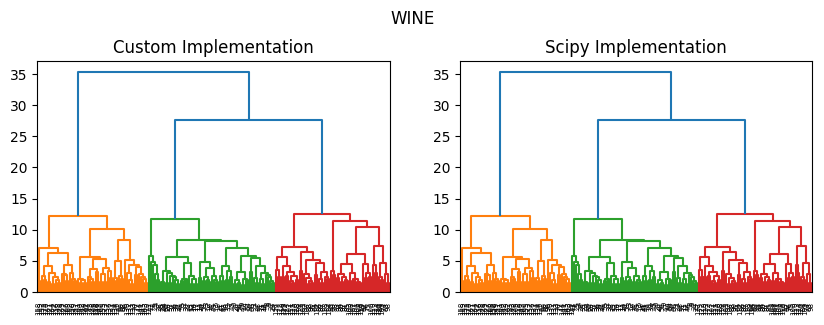

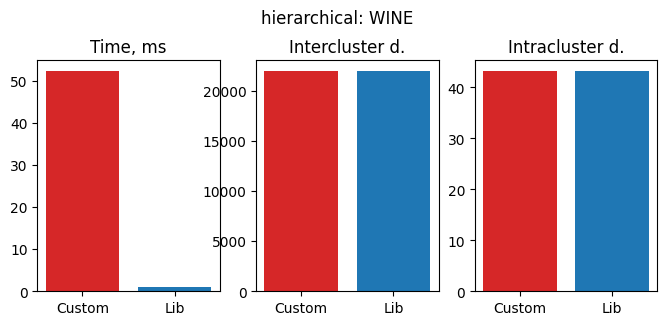

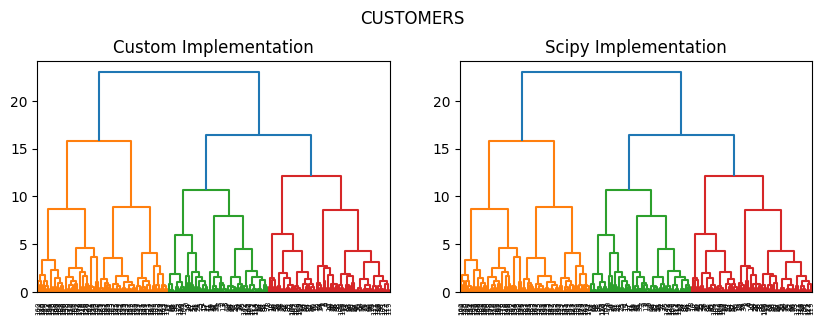

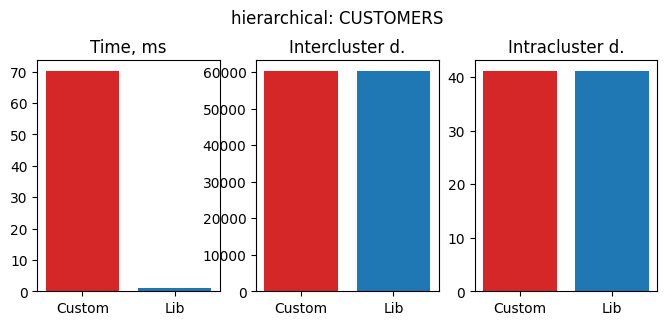

In [7]:
datasets = {'wine': scaled_data_wine, 'customers': scaled_data_customers}

for dataset_name, dataset in datasets.items():
    timers = []
    
    t1 = time.now()
    distances = cdist(dataset, dataset)
    np.fill_diagonal(distances, np.inf)

    pairwise_distances, all_clusters_power = hierarchy(distances)
    linkage_matrix = np.array([]).reshape((0, 4))
    for k, v in pairwise_distances.items():
        row = np.array([k[0], k[1], v, all_clusters_power[k[0]] + all_clusters_power[k[1]]])
        linkage_matrix = np.vstack([linkage_matrix, row])

    t2 = time.now()
    timers += [(t2 - t1).microseconds / 1000]
    
    t1 = time.now()
    linkage_sklearn = hierarchy_lib.linkage(dataset, 'ward')
    t2 = time.now()
    timers += [(t2 - t1).microseconds / 1000]
    
    
    plot_linkage(linkage_matrix, linkage_sklearn, dataset_name)
    
    lbls = hierarchy_lib.fcluster(linkage_matrix, 10, criterion='distance')
    lbls_sklearn = hierarchy_lib.fcluster(linkage_sklearn, 10, criterion='distance')
    
    plot_stats(dataset, lbls, lbls_sklearn, timers, dataset_name, algo='hierarchical')


# EM-алгоритм

## wine

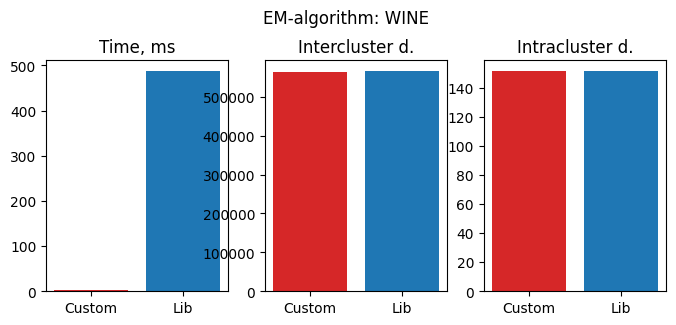

In [8]:
timers = []

N_features = 13
K = 3

t1 = time.now()
lbls = em(scaled_data_wine, N_features, K)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
lbls_sklearn = GaussianMixture(n_components=K, 
                     max_iter=100, 
                     covariance_type='diag'
                    ).fit_predict(scaled_data_wine)

t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

plot_stats(scaled_data_wine, lbls, lbls_sklearn, timers, "wine", algo='EM-algorithm')


In [9]:
data_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=scaled_data_wine)
data_emb_pca = PCA(n_components=2).fit_transform(scaled_data_wine)

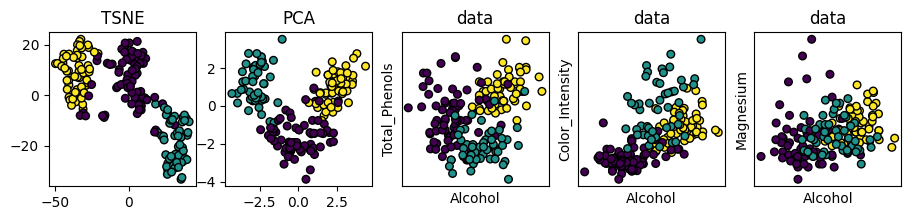

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(11, 2))

colors = lbls.copy()
axes[0].scatter(data_emb_tsne[:, 0], data_emb_tsne[:, 1], s=30, c=colors, edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_emb_pca[:, 0], data_emb_pca[:, 1], s=30, c=colors, edgecolors='k')
axes[1].set_title("PCA")


indexes = [(0, 5), (0, 9), (0, 4)]
axis_idxs = [2, 3, 4]
for i, ax_i in zip(indexes, axis_idxs):
    ax = axes[ax_i]
    i1, i2 = i
    ax.scatter(scaled_data_wine[:, i1], scaled_data_wine[:, i2], s=30, c=colors, edgecolors='k')
    ax.set_xticks([]); ax.set_yticks([])

    ax.set_xlabel(data_wine.columns[i1])
    ax.set_ylabel(data_wine.columns[i2])
    ax.set_title("data")

plt.savefig(f"../fall-24/students/ap-vyugina/lab1/assets/em_wine.png", dpi=120, bbox_inches='tight')

## customers

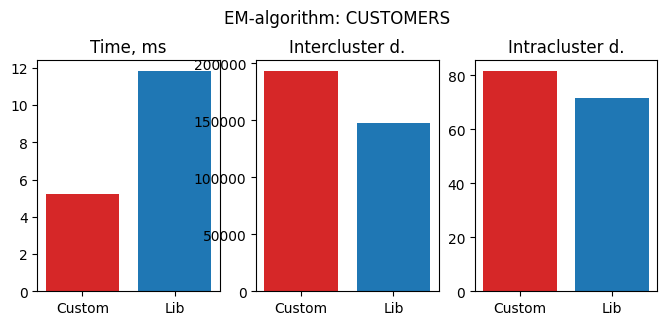

In [13]:
timers = []

N_features = 5
K = 5

t1 = time.now()
lbls = em(scaled_data_customers, N_features, K, max_step=100)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
lbls_sklearn = GaussianMixture(n_components=K, 
                     max_iter=100, 
                     covariance_type='diag'
                    ).fit_predict(scaled_data_customers)

t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

plot_stats(scaled_data_customers, lbls, lbls_sklearn, timers, "customers", algo='EM-algorithm')


In [14]:
data_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=scaled_data_customers)
data_emb_pca = PCA(n_components=2).fit_transform(scaled_data_customers)

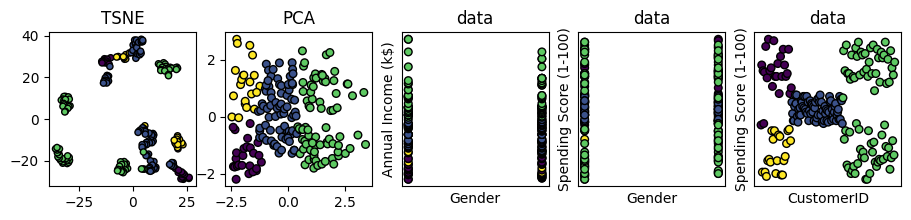

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(11, 2))

colors = lbls.copy()
axes[0].scatter(data_emb_tsne[:, 0], data_emb_tsne[:, 1], s=20, c=colors, edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_emb_pca[:, 0], data_emb_pca[:, 1], s=30, c=colors, edgecolors='k')
axes[1].set_title("PCA")


indexes = [(1, 3), (1, 4), (0, 4)]
axis_idxs = [2, 3, 4]
for i, ax_i in zip(indexes, axis_idxs):
    ax = axes[ax_i]
    i1, i2 = i
    ax.scatter(scaled_data_customers[:, i1], scaled_data_customers[:, i2], s=30, c=colors, edgecolors='k')
    ax.set_xticks([]); ax.set_yticks([])

    ax.set_xlabel(data_customers.columns[i1])
    ax.set_ylabel(data_customers.columns[i2])
    ax.set_title("data")

plt.savefig(f"../fall-24/students/ap-vyugina/lab1/assets/em_customers.png", dpi=120, bbox_inches='tight')

# DBSCAN

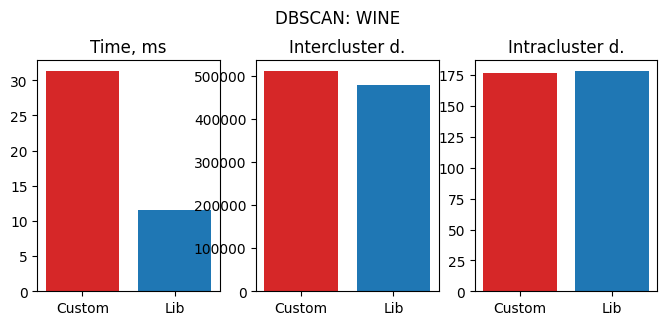

In [16]:
timers = []

N = len(scaled_data_wine)
epsilon = 2.5
min_samples = 15

t1 = time.now()
roles, lbls = dbscan(scaled_data_wine, epsilon, min_samples)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
db = DBSCAN(eps=epsilon, min_samples=min_samples)
lbls_db = db.fit_predict(scaled_data_wine)
roles_db = np.zeros((N, ))
roles_db[db.core_sample_indices_] = 1

t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

plot_stats(scaled_data_wine, lbls, lbls_db, timers, "wine", algo='DBSCAN')


In [17]:
data_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=scaled_data_wine)
data_emb_pca = PCA(n_components=2).fit_transform(scaled_data_wine)

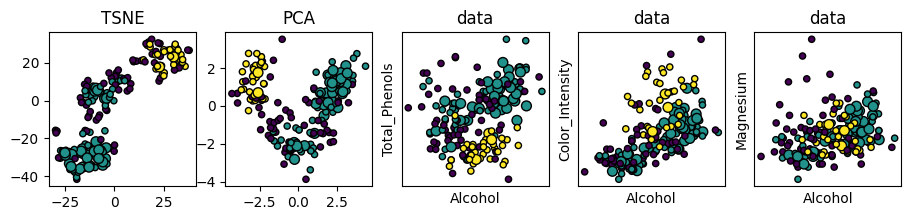

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(11, 2))

N = len(scaled_data_wine)
colors = lbls.copy()
sizes = 20 * np.ones((N, ))
sizes[roles==1] = 50

axes[0].scatter(data_emb_tsne[:, 0], data_emb_tsne[:, 1], s=sizes, c=colors, edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_emb_pca[:, 0], data_emb_pca[:, 1], s=sizes, c=colors, edgecolors='k')
axes[1].set_title("PCA")


indexes = [(0, 5), (0, 9), (0, 4)]
axis_idxs = [2, 3, 4]
for i, ax_i in zip(indexes, axis_idxs):
    ax = axes[ax_i]
    i1, i2 = i
    ax.scatter(scaled_data_wine[:, i1], scaled_data_wine[:, i2], s=sizes, c=colors, edgecolors='k')
    ax.set_xticks([]); ax.set_yticks([])

    ax.set_xlabel(data_wine.columns[i1])
    ax.set_ylabel(data_wine.columns[i2])
    ax.set_title("data")

plt.savefig(f"../fall-24/students/ap-vyugina/lab1/assets/dbscan_wine.png", dpi=120, bbox_inches='tight')

## customers

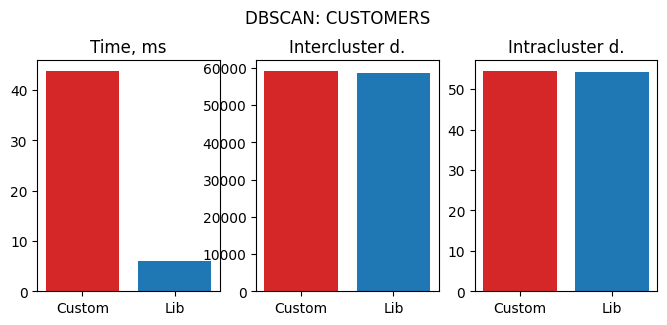

In [19]:
timers = []

N = len(scaled_data_customers)
epsilon = 1
min_samples = 10

t1 = time.now()
roles, lbls = dbscan(scaled_data_customers, epsilon, min_samples)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
db = DBSCAN(eps=epsilon, min_samples=min_samples)
lbls_db = db.fit_predict(scaled_data_customers)
roles_db = np.zeros((N, ))
roles_db[db.core_sample_indices_] = 1

t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

plot_stats(scaled_data_customers, lbls, lbls_db, timers, "customers", algo='DBSCAN')


In [20]:
data_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=scaled_data_customers)
data_emb_pca = PCA(n_components=2).fit_transform(scaled_data_customers)

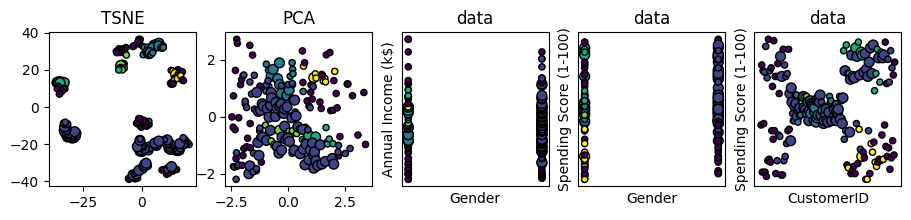

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(11, 2))

colors = lbls.copy()
N = len(scaled_data_customers)
sizes = 20 * np.ones((N, ))
sizes[roles==1] = 50

axes[0].scatter(data_emb_tsne[:, 0], data_emb_tsne[:, 1], s=sizes, c=colors, edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_emb_pca[:, 0], data_emb_pca[:, 1], s=sizes, c=colors, edgecolors='k')
axes[1].set_title("PCA")


indexes = [(1, 3), (1, 4), (0, 4)]
axis_idxs = [2, 3, 4]
for i, ax_i in zip(indexes, axis_idxs):
    ax = axes[ax_i]
    i1, i2 = i
    ax.scatter(scaled_data_customers[:, i1], scaled_data_customers[:, i2], s=sizes, c=colors, edgecolors='k')
    ax.set_xticks([]); ax.set_yticks([])

    ax.set_xlabel(data_customers.columns[i1])
    ax.set_ylabel(data_customers.columns[i2])
    ax.set_title("data")

plt.savefig(f"../fall-24/students/ap-vyugina/lab1/assets/dbscan_customers.png", dpi=120, bbox_inches='tight')